In [118]:
import requests
import numpy as np
import pandas as pd
import math

import json
import time
from datetime import datetime, timedelta
import sgp4
from sgp4.api import Satrec, WGS72
from sgp4.conveniences import jday
from sgp4.ext import invjday

import matplotlib.pyplot as plt

In [2]:
def get_tle():
    # Space-Track API의 URL
    url = "https://www.space-track.org/ajaxauth/login"

    # 요청에 필요한 인증 정보
    payload = {"identity": '', "password": ''}

    # Session 객체 생성
    session = requests.Session()

    # 로그인 요청
    response = session.post(url, data=payload)

    if response.status_code != 200:
        print("로그인에 실패했습니다.")
        return None

    # TLE 요청
    response = session.get(
        f"https://www.space-track.org/basicspacedata/query/class/tle/NORAD_CAT_ID/58400/EPOCH/2023-11-22--2024-07-04/orderby/EPOCH%20asc/format/3le/emptyresult/show"
    )#

    return response

In [3]:
response = get_tle()
tle_datas = response.text.split('\r\n')

tle_first_lst = []
tle_second_lst = []

for i in range(0, len(tle_datas)-2, 3):
    tle_first_lst.append(tle_datas[i+1])
    tle_second_lst.append(tle_datas[i+2])

tle_df = pd.DataFrame({'first_line':tle_first_lst, 'second_line':tle_second_lst})
tle_df.drop_duplicates(keep='first', inplace=True)
tle_df.reset_index(inplace=True, drop=True)

In [4]:
change_times = []
for i in range(len(tle_df)):
    tle_1, tle_2 = tle_df['first_line'].iloc[i], tle_df['first_line'].iloc[i]
    satellite = Satrec.twoline2rv(tle_1,tle_2)
    jdsatepoch = satellite.jdsatepoch
    jdsatepochfrac = satellite.jdsatepochF
    epochdatetime = invjday(jdsatepoch + jdsatepochfrac)
    change_times.append(epochdatetime)

In [5]:
change_df = pd.DataFrame(change_times)
change_df.columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
change_df['first_line']=tle_df['first_line']
change_df['second_line']=tle_df['second_line']
change_df['time'] = change_df['year'].astype('str') + '-' + change_df['month'].astype('str') + '-' + change_df['day'].astype('str') + ' ' + change_df['hour'].astype('str') + ':' + change_df['minute'].astype('str') + ':' + change_df['second'].astype('int').astype('str')
change_df['time'] = pd.to_datetime(change_df['time'])

In [6]:
epoch = datetime(2023,11, 22, 0, 15, 0)
all_info = []

earth_radius = 6378.137
rad2deg = 180.0 / 3.141592653589793

while epoch < datetime(2024, 7, 4, 0, 0, 0):
    # print(epoch)
    year = epoch.year
    month = epoch.month
    date = epoch.day
    hour = epoch.hour
    minute = epoch.minute

    now_time = str(year) +'-' + str(month) + '-' + str(date) + ' ' + str(hour) + ':' + str(minute) + ':' + str(0)
    temp = change_df[change_df['time'] <= pd.to_datetime(now_time)].copy()

    jd, fr =jday(year, month, date, hour, minute, 0)

    tle1,tle2 = temp.iloc[-1]['first_line'], temp.iloc[-1]['second_line']
    satellite = Satrec.twoline2rv(tle1, tle2)

    e, position, velocity = satellite.sgp4(jd, fr)

    all_info.append([len(temp), tle1, tle2,
                     year, month, date, hour, minute, 
                     position[0], position[1], position[2], velocity[0], velocity[1], velocity[2],
                     (position[0]**2 + position[1]**2 + position[2]**2)**0.5, (velocity[0]**2 + velocity[1]**2 + velocity[2]**2)**0.5,
                     satellite.alta * earth_radius , satellite.altp * earth_radius,
                     satellite.inclo*rad2deg, satellite.ecco, satellite.nodeo])

    epoch += timedelta(minutes=1)

In [49]:
info_df = pd.DataFrame(all_info)
info_df.columns = ['change', 'tle1','tle2',
                    'year', 'month', 'day', 'hour', 'minute', 
                   'x', 'y', 'z', 'vx', 'vy', 'vz',
                    'altitude', 'velocity', 
                    'apogee', 'perigee', 
                    'inclination', 'eccentricity', 'raan']
# info_df['change'] = (info_df['change'].diff().fillna(1)>=1) * 1

In [51]:
info_df.to_csv('info_df.csv', index=False)

In [52]:
info_df = pd.read_csv('info_df.csv')
info_wo_tle_df = info_df.drop(['tle1', 'tle2'], axis=1).copy()
info_wo_tle_df['time'] = info_wo_tle_df['year'].astype(str) + '-' + info_wo_tle_df['month'].astype(str) + '-' + info_wo_tle_df['day'].astype(str) + ' ' + info_wo_tle_df['hour'].astype(str) + ':' + info_wo_tle_df['minute'].astype(str) + ':' + '00' 
info_wo_tle_df['time'] = pd.to_datetime(info_wo_tle_df['time'])
info_wo_tle_df.set_index('time', inplace=True)
info_wo_tle_df.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1, inplace=True)

In [59]:
five_min_df = info_wo_tle_df[::5].copy()
five_min_df['change'] = (five_min_df['change'].diff().fillna(1)>=1) * 1

hour_df = info_wo_tle_df[::60].copy()
hour_df['change'] = (hour_df['change'].diff().fillna(1)>=1) * 1

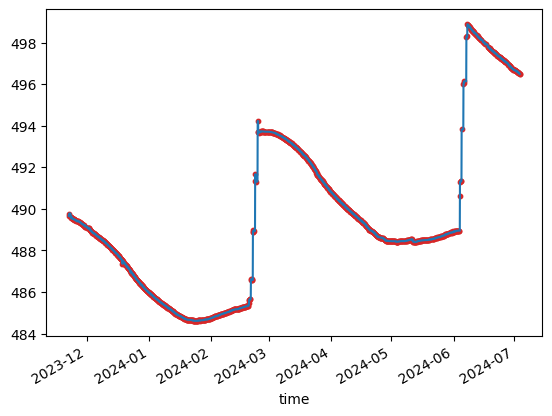

In [81]:
hour_df['perigee'].plot()
plt.scatter(hour_df[hour_df['change']==1].index, hour_df[hour_df['change']==1]['perigee'], c='tab:red',s=10)

<Axes: xlabel='time'>

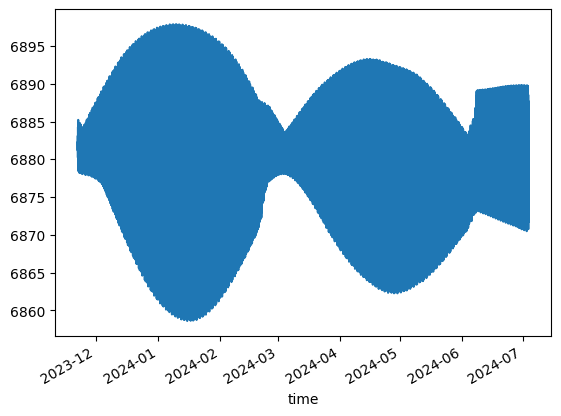

In [179]:
hour_df['altitude'].plot()

<Axes: xlabel='time'>

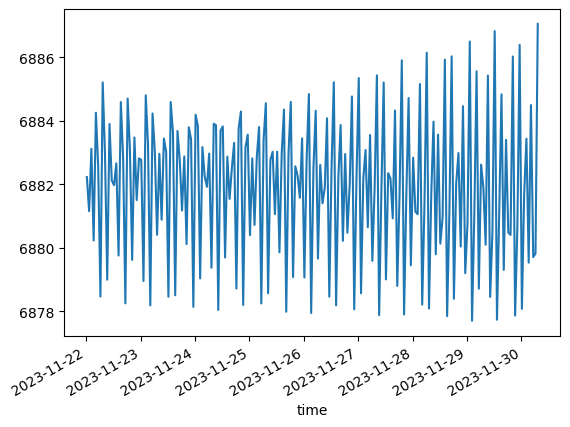

In [182]:
hour_df['altitude'].iloc[:200].plot()

<Axes: xlabel='time'>

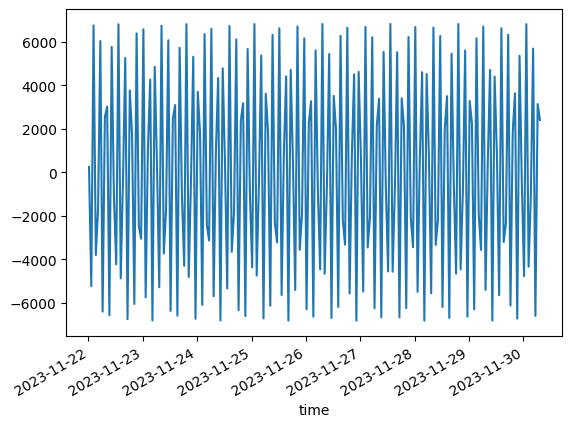

In [189]:
hour_df['z'].iloc[:200].plot()

<Axes: xlabel='time'>

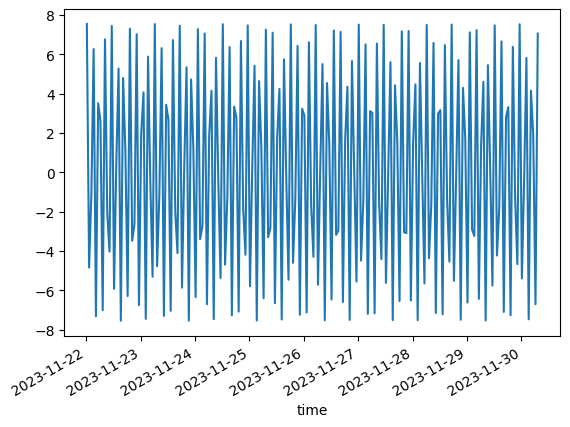

In [192]:
hour_df['vz'].iloc[:200].plot()

<Axes: xlabel='time'>

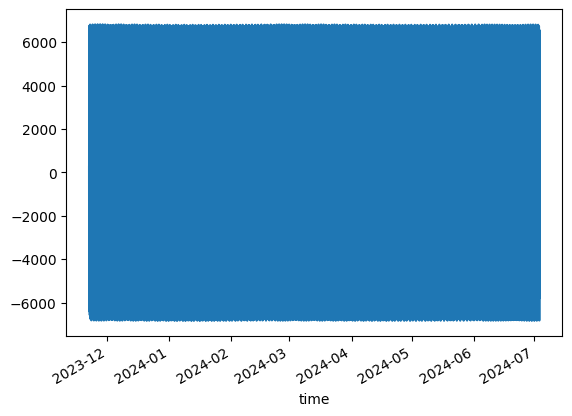

In [188]:
hour_df['z'].plot()

<Axes: xlabel='time'>

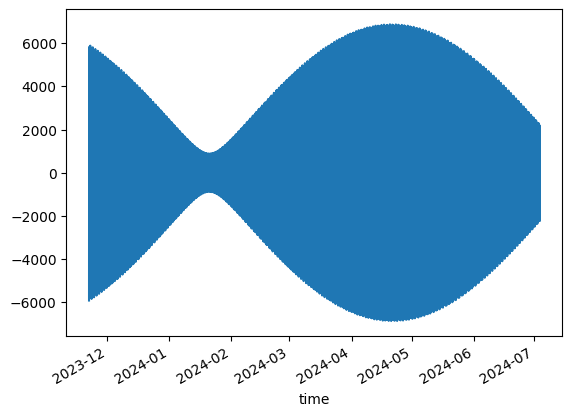

In [185]:
hour_df['x'].plot()

In [169]:
hour_df[hour_df['change']==1]

,change,x,y,z,vx,vy,vz,altitude,velocity,apogee,perigee,inclination,eccentricity,raan
time,,,,,,,,,,,,,,
2023-11-22 00:15:00,1,-5925.192816,-3491.908920,252.527907,-0.263022,0.987328,7.544119,6882.231336,7.612998,509.278908,489.663968,97.4276,0.001426,3.678915
2023-11-22 04:15:00,1,5836.865233,3247.412591,-1666.828724,-1.106905,-1.775259,-7.316924,6884.257569,7.610135,509.119343,489.776822,97.4263,0.001406,3.681657
2023-11-22 21:15:00,1,1617.562239,1976.650317,6392.075007,6.241948,3.443276,-2.641770,6883.478551,7.602435,509.236465,489.592802,97.4275,0.001428,3.693639
2023-11-22 23:15:00,1,5446.000296,2900.173851,-3050.123957,-2.434528,-2.539059,-6.748475,6882.818009,7.610235,509.217319,489.572337,97.4261,0.001428,3.695167
2023-11-23 05:15:00,1,3772.146181,3101.357861,4852.339169,4.952855,2.278077,-5.303085,6884.235819,7.605466,509.139757,489.626856,97.4263,0.001419,3.699690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-02 22:15:00,1,-717.929697,-4318.923208,5298.361533,-2.463732,-5.425092,-4.744237,6873.220182,7.616389,501.343088,496.573135,97.4028,0.000347,1.247670
2024-07-03 06:15:00,1,-1539.530257,-5966.575876,3054.107736,-1.898886,-2.977548,-6.747786,6877.336342,7.616047,501.348573,496.544242,97.4028,0.000349,1.253312
2024-07-03 14:15:00,1,-2073.724076,-6556.639654,262.333172,-1.025331,0.011090,-7.543847,6881.763858,7.613216,501.347166,496.515338,97.4027,0.000351,1.258957


In [165]:
hour_df['perigee']

time
2023-11-22 00:15:00    489.663968
2023-11-22 01:15:00    489.663968
2023-11-22 02:15:00    489.663968
2023-11-22 03:15:00    489.663968
2023-11-22 04:15:00    489.776822
                          ...    
2024-07-03 19:15:00    496.515338
2024-07-03 20:15:00    496.515338
2024-07-03 21:15:00    496.515338
2024-07-03 22:15:00    496.496507
2024-07-03 23:15:00    496.492544
Name: perigee, Length: 5400, dtype: float64

In [173]:
window = 500
perigee_diff = hour_df['perigee'].diff().fillna(0)
ol_idxs = []
for i in range(window,5400 - window,1):
    window_diff = perigee_diff[i-window : i]
    z_norm = ((window_diff - window_diff.mean())/window_diff.std())
    final_val = float(z_norm.values[-1])

    if final_val < -3:
        raise
        ol_idxs.append(i)
    elif final_val > 3:
        raise
        ol_idxs.append(i)
    else:
        pass

RuntimeError: No active exception to reraise

In [177]:
hour_df[hour_df['perigee'].diff() == 0]

,change,x,y,z,vx,vy,vz,altitude,velocity,apogee,perigee,inclination,eccentricity,raan
time,,,,,,,,,,,,,,
2023-11-22 01:15:00,0,4142.923806,1677.561052,-5231.851460,-4.689845,-3.532785,-4.838115,6881.155313,7.608059,509.278908,489.663968,97.4276,0.001426,3.678915
2023-11-22 02:15:00,0,384.268670,1256.609060,6756.523879,6.530679,3.742065,-1.065038,6883.120199,7.601784,509.278908,489.663968,97.4276,0.001426,3.678915
2023-11-22 03:15:00,0,-4648.016880,-3360.669051,-3799.926646,-4.060042,-1.479319,6.266571,6880.232547,7.611980,509.278908,489.663968,97.4276,0.001426,3.678915
2023-11-22 05:15:00,0,-3154.252544,-976.091126,6038.857223,5.532460,3.857507,3.512676,6882.576520,7.604431,509.119343,489.776822,97.4263,0.001406,3.681657
2023-11-22 06:15:00,0,-1604.749756,-1940.093354,-6401.099020,-6.293102,-3.391083,2.603543,6878.462958,7.607957,509.119343,489.776822,97.4263,0.001406,3.681657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-03 17:15:00,0,-1124.586323,-5319.476908,4208.029859,-2.167005,-4.251880,-5.936000,6875.248670,7.616462,501.347166,496.515338,97.4027,0.000351,1.258957
2024-07-03 18:15:00,0,2201.543768,6419.376068,1146.119667,0.528764,-1.522287,7.439587,6882.497683,7.612122,501.347166,496.515338,97.4027,0.000351,1.258957
2024-07-03 19:15:00,0,-1823.920986,-3252.959433,-5791.666993,1.455875,6.295018,-3.998281,6888.529552,7.598229,501.347166,496.515338,97.4027,0.000351,1.258957


In [172]:
z_norm

time
2024-01-30 04:15:00   -1.800049
2024-01-30 05:15:00   -1.740883
2024-01-30 06:15:00   -1.740883
2024-01-30 07:15:00   -1.740883
2024-01-30 08:15:00   -1.740883
                         ...   
2024-02-19 19:15:00    1.579201
2024-02-19 20:15:00    2.137755
2024-02-19 21:15:00    2.137755
2024-02-19 22:15:00    2.137755
2024-02-19 23:15:00    3.041299
Name: perigee, Length: 500, dtype: float64

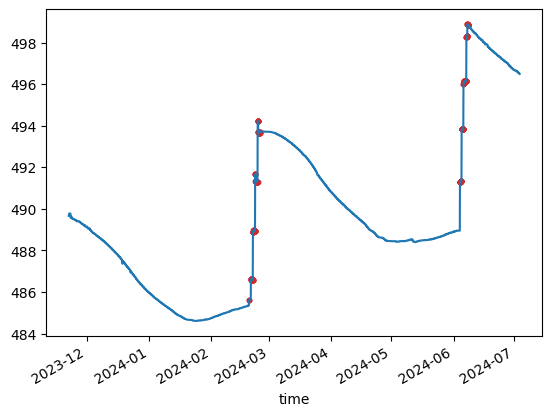

In [167]:
hour_df['perigee'].plot()
plt.scatter(hour_df.iloc[ol_idxs].index, hour_df.iloc[ol_idxs]['perigee'], c='tab:red',s=10)